# Insight From Visualization
1. Process image data
2. Extract information from visual
3. Using visualization to guide your analysis


##### Covid19

Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus.

Most people infected with the virus will experience mild to moderate respiratory illness and recover without requiring special treatment. However, some will become seriously ill and require medical attention. Older people and those with underlying medical conditions like cardiovascular disease, diabetes, chronic respiratory disease, or cancer are more likely to develop serious illness. Anyone can get sick with COVID-19 and become seriously ill or die at any age. 

The best way to prevent and slow down transmission is to be well informed about the disease and how the virus spreads. Protect yourself and others from infection by staying at least 1 metre apart from others, wearing a properly fitted mask, and washing your hands or using an alcohol-based rub frequently. Get vaccinated when it’s your turn and follow local guidance.

The virus can spread from an infected person’s mouth or nose in small liquid particles when they cough, sneeze, speak, sing or breathe. These particles range from larger respiratory droplets to smaller aerosols. It is important to practice respiratory etiquette, for example by coughing into a flexed elbow, and to stay home and self-isolate until you recover if you feel unwell.

<div style="text-align: center;">
    <img src="covid19.png" alt="Alt Text">
</div>

Reference: 
1. https://www.who.int/health-topics/coronavirus#tab=tab_1
2. https://health.wyo.gov/publichealth/infectious-disease-epidemiology-unit/disease/novel-coronavirus/

# Introduction

In this notebook, the COVID-19 detection is performed using the [COVID-19 Chest X-ray Image Dataset](https://www.kaggle.com/bachrr/covid-chest-xray). The dataset contains chest X-ray images of normal and COVID-19 affected patients. Here, a convolutional neural network is adopted to extract features and classify images as normal and COVID-19 affected.

Data Reference: https://www.kaggle.com/datasets/bachrr/covid-chest-xray/data

In [8]:
# import the necessary packages
import numpy as np
import pandas as pd
import shutil

import matplotlib.pyplot as plt
from PIL import Image

import os
os.getcwd()

'C:\\Users\\yjyzx\\Github\\PythonIntroAndDataModeling\\notebooks\\BAN7201DataVisualization'

In [2]:
### Split image data to different folder based on the label in the Excel file, matadata
covid_dataset_path = '../../data/Covid19ChestXRay/'
df = pd.read_csv(covid_dataset_path + 'metadata.csv')

In [28]:
# ### create folder
# ### uncomment this cell if execution needed. 

# !mkdir C:\\Users\\yjyzx\\Github\\PythonIntroAndDataModeling\\data\\Covid19ChestXRay\\Covid
# !mkdir C:\\Users\\yjyzx\\Github\\PythonIntroAndDataModeling\\data\\Covid19ChestXRay\\NonCovid

### Data Preparing
1. We need to split the image data to covid and noncovid folder. 
2. Since the original data contains both X-Ray image and CT image. We want to build a accurate model for X-Ray image. Then, filter out the image is important. 

In [34]:
source_path = 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images/'
covid_path = 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images_split/Covid'
noncovid_path = 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images_split/NonCovid'

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 and (2) is X-Ray image
    if "COVID-19" in row["finding"] and row["modality"] == "X-ray":
        shutil.copy(source_path + row['filename'], covid_path)

    else:
        shutil.copy(source_path + row['filename'], noncovid_path)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images/radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.nii.gz'

In [5]:
### The above error message suggests that filename in the Excel file doesn't match image files in the images folder
### We shall ignore the filenames that do not exsit in the images folder. 

source_path = 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images/'
covid_path = 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images_split/Covid'
noncovid_path = 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images_split/NonCovid'

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    imagePath = source_path + row['filename']
    # if (1) the current path exsits and (2) is X-Ray image
    if os.path.exists(imagePath) and row["modality"] == "X-ray":
        # if the current case is COVID-19
        if "COVID-19" in row["finding"]:
            shutil.copy(imagePath, covid_path)
        else:
            shutil.copy(imagePath, noncovid_path)
    else:
        continue

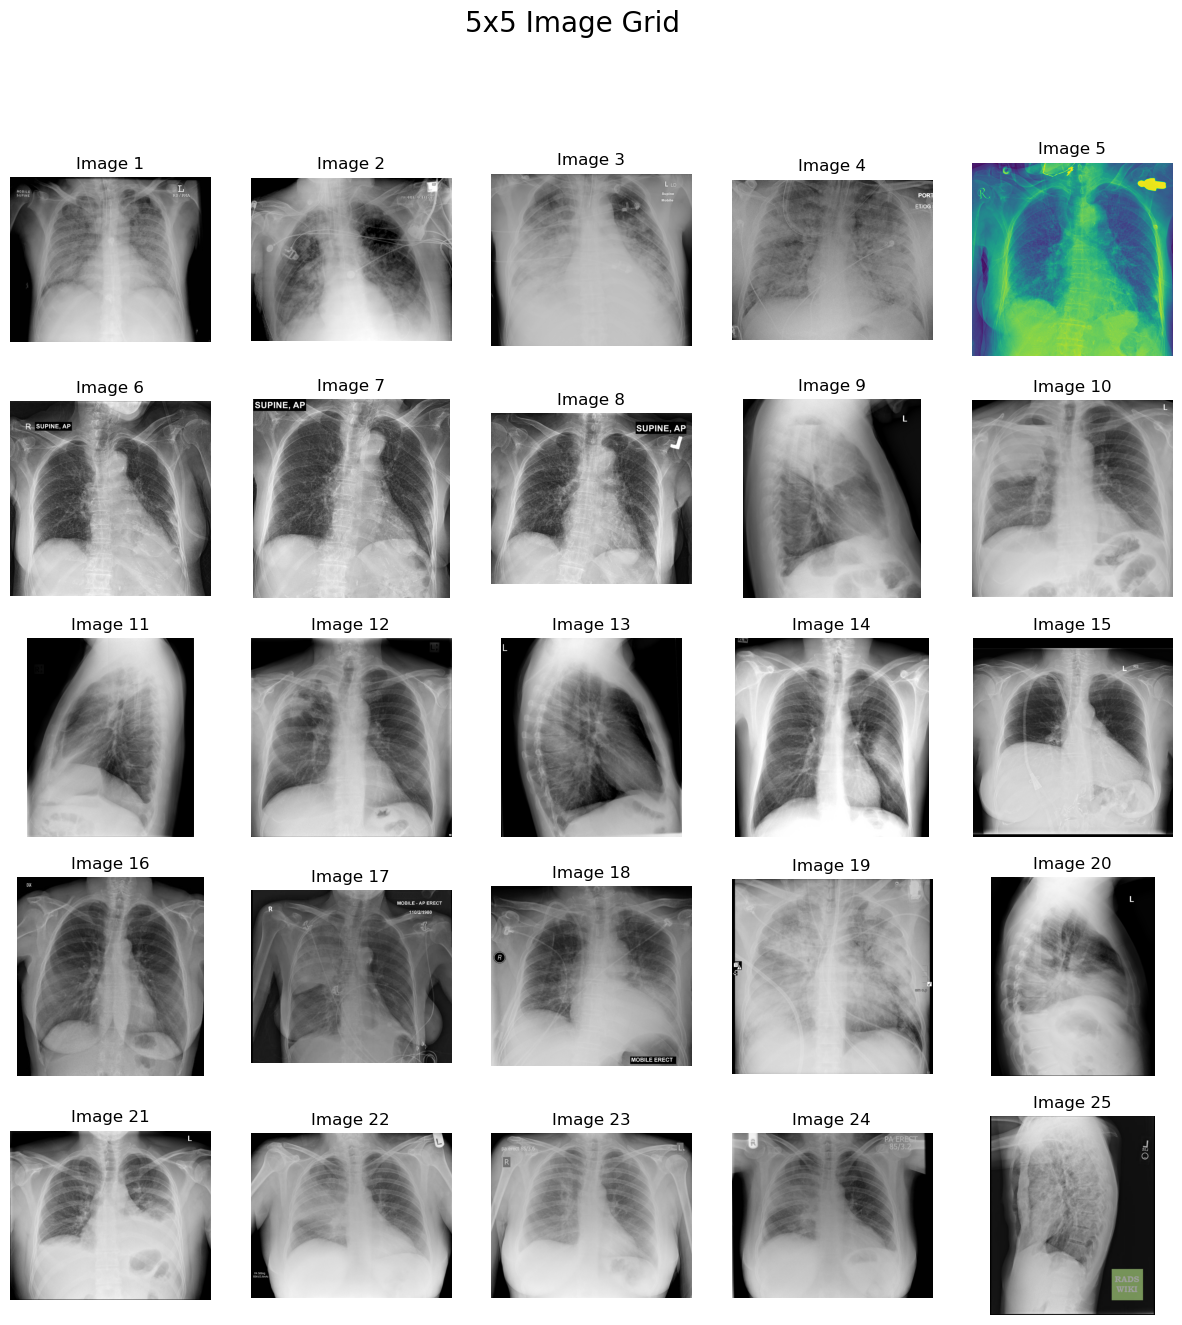

In [11]:
### Help function to plot the chest X-ray image
def show_images_grid(folder_path):
    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    # Limit to 25 images for 5x5 grid
    image_files = image_files[:25]
    
    # Set up the plot
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    fig.suptitle("5x5 Image Grid", fontsize=20)
    
    for idx, img_file in enumerate(image_files):
        # Read the image
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        
        # Plot image
        ax = axes[idx // 5, idx % 5]
        ax.imshow(img)
        ax.axis('off')  # Hide axis
        ax.set_title(f"Image {idx + 1}")

    # Hide any extra axes
    for idx in range(len(image_files), 25):
        axes[idx // 5, idx % 5].axis('off')

    plt.show()

# Provide image folder path
show_images_grid(noncovid_path)

# Model Building
### Step 1: Import libraries

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
data_dir = 'C:/Users/yjyzx/Github/PythonIntroAndDataModeling/data/Covid19ChestXRay/images_split/'


### Step 2 Data Preprocessing and Augmentation

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizes the input image to 128x128 pixels (width x height). Ensures all images have a consistent size.
    transforms.ToTensor(),          # Converts the image from a PIL image or NumPy array to a PyTorch tensor.
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean, std)
])

# Why Use These Transformations?
# Resizing: Ensures consistent input size for neural networks.

# ToTensor: Converts image data into a format compatible with PyTorch models.

# Normalization: Improves training stability and convergence by standardizing pixel values.

# Load dataset
dataset = ImageFolder(root = data_dir, transform = transform)
class_names = dataset.classes  # Should be ['Covid', 'NonCovid']
print("Classes:", class_names)

# Split into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)


Classes: ['Covid', 'NonCovid']


### Step 3: Visualize a few images after processing

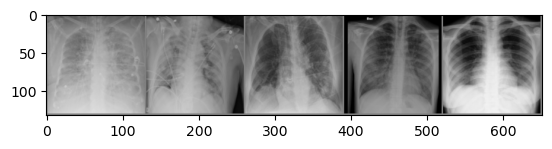

['Covid', 'Covid', 'Covid', 'NonCovid', 'NonCovid']


In [14]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# View a batch of images
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:5]))
print([class_names[label] for label in labels[:5]])

### Step 4: Define the CNN Model

A convolutional neural network (CNN) is a mathematical model that uses layers to process images and other data. CNNs are often used for image classification, facial recognition, and optical character recognition. 


In [16]:
class CovidClassifier(nn.Module):
    def __init__(self):
        super(CovidClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # Output layer: 2 classes (covid, noncovid)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Model instance
model = CovidClassifier().to(device)


### Step 5: Define Loss Function and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### Step 6: Training

In [18]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed!")

Epoch [1/10], Loss: 0.5680
Epoch [2/10], Loss: 0.4769
Epoch [3/10], Loss: 0.4626
Epoch [4/10], Loss: 0.4853
Epoch [5/10], Loss: 0.4357
Epoch [6/10], Loss: 0.4689
Epoch [7/10], Loss: 0.3874
Epoch [8/10], Loss: 0.4102
Epoch [9/10], Loss: 0.3877
Epoch [10/10], Loss: 0.3774
Training completed!


### Step 7: Evaluate the Model

In [20]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 77.27%


### Step 8: Predict on a New Image

In [19]:
### Please try any image data in the folder. 
### uncomment the bottom 2 lines to before run. 

from PIL import Image

def predict_image(image_path):
    model.eval()
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
    
    print("Predicted:", class_names[predicted.item()])

# # Example prediction
# predict_image("path/to/test_image.jpg")

### Overfitting and Underfitting

<div style="text-align: center;">
    <img src="Overfitting.png" alt="Alt Text", width = 50%>
</div>

<div style="text-align: center;">
    <img src="OverfittingUnderfitting.png" alt="Alt Text", width = '50%'>
</div>

<div style="text-align: center;">
    <img src="OU1.png" alt="Alt Text", width = '50%'>
</div>

<div style="text-align: center;">
    <img src="OU2.png" alt="Alt Text" width = '50%'>
</div>

<div style="text-align: center;">
    <img src="OU3.png" alt="Alt Text" width = '50%'>
</div>

### Conclusion
In this project, the key take aways are:
1. manage data files on your operation system
2. prepare image data using advanced model
3. using visulziation to giude your model building and validation
4. identify Overfitting and Underfitting using visulization

Please note that in the context of data visualization, we study the principles of visual to build good visualization. Also, we need to know how to process image data to help our decision making process.

Based on the accuracy above, this model is not perfect. Can you come up with some ideas to improve it?